# Telecom Churn - Case Stud

In [75]:
# Importing packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [76]:
# lets import the dataset
data_tel = pd.read_csv("telecom_churn_data.csv")
data_tel.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
# dimensions
data_tel.shape

(99999, 226)

# Filter Customers

In [77]:
# High-value customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of 
# the average recharge amount in the first two months (the good phase)

# lets dervie features to extract high value customers
# lets find out total amount spent by customers on data recharge,we have two colums available to find this out 
# first column is av_rech_amt_data_x (x represents month here, would be either 6 or 7 or 8)
# second column is total_rech_data_x (x represnts month here, would be either 6 or 7 or 8)
# lets introduce a new column total_rech_data_amt_x which can be calculated as av_rech_amt_data_x * total_rech_data_x

data_tel['total_rech_data_amt_6'] = data_tel['av_rech_amt_data_6'] * data_tel['total_rech_data_6']
data_tel['total_rech_data_amt_7'] = data_tel['av_rech_amt_data_7'] * data_tel['total_rech_data_7']
data_tel['total_rech_data_amt_8'] = data_tel['av_rech_amt_data_8'] * data_tel['total_rech_data_8']
data_tel['total_rech_data_amt_9'] = data_tel['av_rech_amt_data_9'] * data_tel['total_rech_data_9']

# now we dont need columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8) , lets drop them
data_tel.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

# lets find out the average recharge done in the first two months(june & july) - the good phase
# total amount spend would be the sum of total data recharge done & total call/sms recharges
data_tel_temp = (data_tel['total_rech_amt_6'].fillna(0) 
+ data_tel['total_rech_amt_7'].fillna(0) 
+ data_tel['total_rech_data_amt_6'].fillna(0) 
+ data_tel['total_rech_data_amt_7'].fillna(0))/2

# take 70 percentile of the calculated average amount
data_tel70= np.percentile(data_tel_temp, 70.0)
print("70 percentile is : ",data_tel70 )

# fitler the given data set based on 70th percentile
data_telhv = data_tel[data_tel_temp >= data_tel70]

print("Dimensions of the filtered dataset:",data_telhv.shape)

70 percentile is :  478.0
Dimensions of the filtered dataset: (30001, 222)


In [78]:
# lets introduce a new column "churn", values would be either 1 (churn) or 0 (non-churn)
# we will calculate churn/non-churn based on the usage as mentioned in the problem statement
data_telhv['churn'] = np.where(data_telhv[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
data_telhv.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


In [79]:
# lets find out churn/non churn percentage
data_telhv['churn'].value_counts()/len(data_telhv)*100

#observation : 91% of the customers do not churn, this might be a case of class imbalance, we will treat it later

0    91.863605
1     8.136395
Name: churn, dtype: float64

In [80]:
# lets check the unique value columns and drop them as they are give us no additional info or insight into the data
for i in data_telhv.columns:
    if data_telhv[i].nunique() == 1:
        
        data_telhv.drop(i,axis=1,inplace = True)

print("\nDimension of the updated dataset:",data_telhv.shape)


Dimension of the updated dataset: (30001, 207)


In [81]:
# lets check the null values present in the dataset
(data_telhv.isnull().sum() * 100 / len(data_telhv)).sort_values(ascending = False)

total_rech_data_amt_9    49.268358
count_rech_3g_9          49.268358
arpu_3g_9                49.268358
arpu_2g_9                49.268358
night_pck_user_9         49.268358
                           ...    
last_day_rch_amt_7        0.000000
last_day_rch_amt_8        0.000000
last_day_rch_amt_9        0.000000
vol_2g_mb_6               0.000000
mobile_number             0.000000
Length: 207, dtype: float64

In [82]:
# Drop Columns with > 30% of missing values except 9th Month's columns
cols = data_telhv.columns
data_telhv_null = data_telhv.isnull().sum() * 100 / len(data_telhv)
data_telhv_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': data_telhv_null})

cols_to_drop = data_telhv_null_df.loc[(data_telhv_null_df["col_name"].str.contains('_9')==False) & (data_telhv_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",cols_to_drop)

# lets drop these columns
data_telhv.drop(cols_to_drop, axis=1,inplace = True)
data_telhv.shape

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

(30001, 180)

In [83]:
# lets check for columns that can be changed to integers, floats or date types
cols_types = data_telhv.select_dtypes(include=['object'])
print(cols_types.iloc[0])

# observation : all the columns below can be converted to date type

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [84]:
# convert to datetime
for col in cols_types.columns:
    data_telhv[col] = pd.to_datetime(data_telhv[col])

data_telhv.shape

(30001, 180)

In [86]:
# lets check the correlation amongst the features, drop the highly correlated ones
cor = data_telhv.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [87]:
# we will drop the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
data_telhv.drop(drop_col_list, axis=1, inplace=True)
data_telhv.shape

(30001, 125)

In [88]:
# lets check the dataset again
(data_telhv.isnull().sum() * 100 / len(data_telhv)).sort_values(ascending = False)

# Obervation : we are left with few columns with around 4% of null values

date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
total_rech_data_amt_9       49.268358
fb_user_9                   49.268358
arpu_3g_9                   49.268358
                              ...    
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
vol_2g_mb_9                  0.000000
vol_3g_mb_9                  0.000000
mobile_number                0.000000
Length: 125, dtype: float64

In [89]:
# drop rows with null values
data_telhv = data_telhv[~np.isnan(data_telhv['onnet_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['onnet_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['onnet_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['offnet_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['offnet_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['offnet_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_ic_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_ic_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_ic_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_og_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_og_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['roam_og_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_t2c_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_t2c_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_t2c_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_og_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_t2f_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_t2f_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_t2f_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_og_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_og_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_og_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_og_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_og_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_og_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_og_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['og_others_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['og_others_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['og_others_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_ic_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_ic_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['loc_ic_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2t_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2t_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2t_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2f_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2f_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_t2f_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['std_ic_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_ic_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_ic_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['spl_ic_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_ic_mou_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_ic_mou_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['isd_ic_mou_8'])]
data_telhv = data_telhv[~np.isnan(data_telhv['ic_others_6'])]
data_telhv = data_telhv[~np.isnan(data_telhv['ic_others_7'])]
data_telhv = data_telhv[~np.isnan(data_telhv['ic_others_8'])]

In [90]:
# lets check the dataset again
(data_telhv.isnull().sum() * 100 / len(data_telhv)).sort_values(ascending = False)

date_of_last_rech_data_9    48.309009
max_rech_data_9             48.309009
fb_user_9                   48.309009
total_rech_data_amt_9       48.309009
arpu_3g_9                   48.309009
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_9               0.000000
last_day_rch_amt_6           0.000000
last_day_rch_amt_7           0.000000
mobile_number                0.000000
Length: 125, dtype: float64

In [91]:
# lets write a function to plot historgram for some sample columns
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [92]:
# function to plot correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [93]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


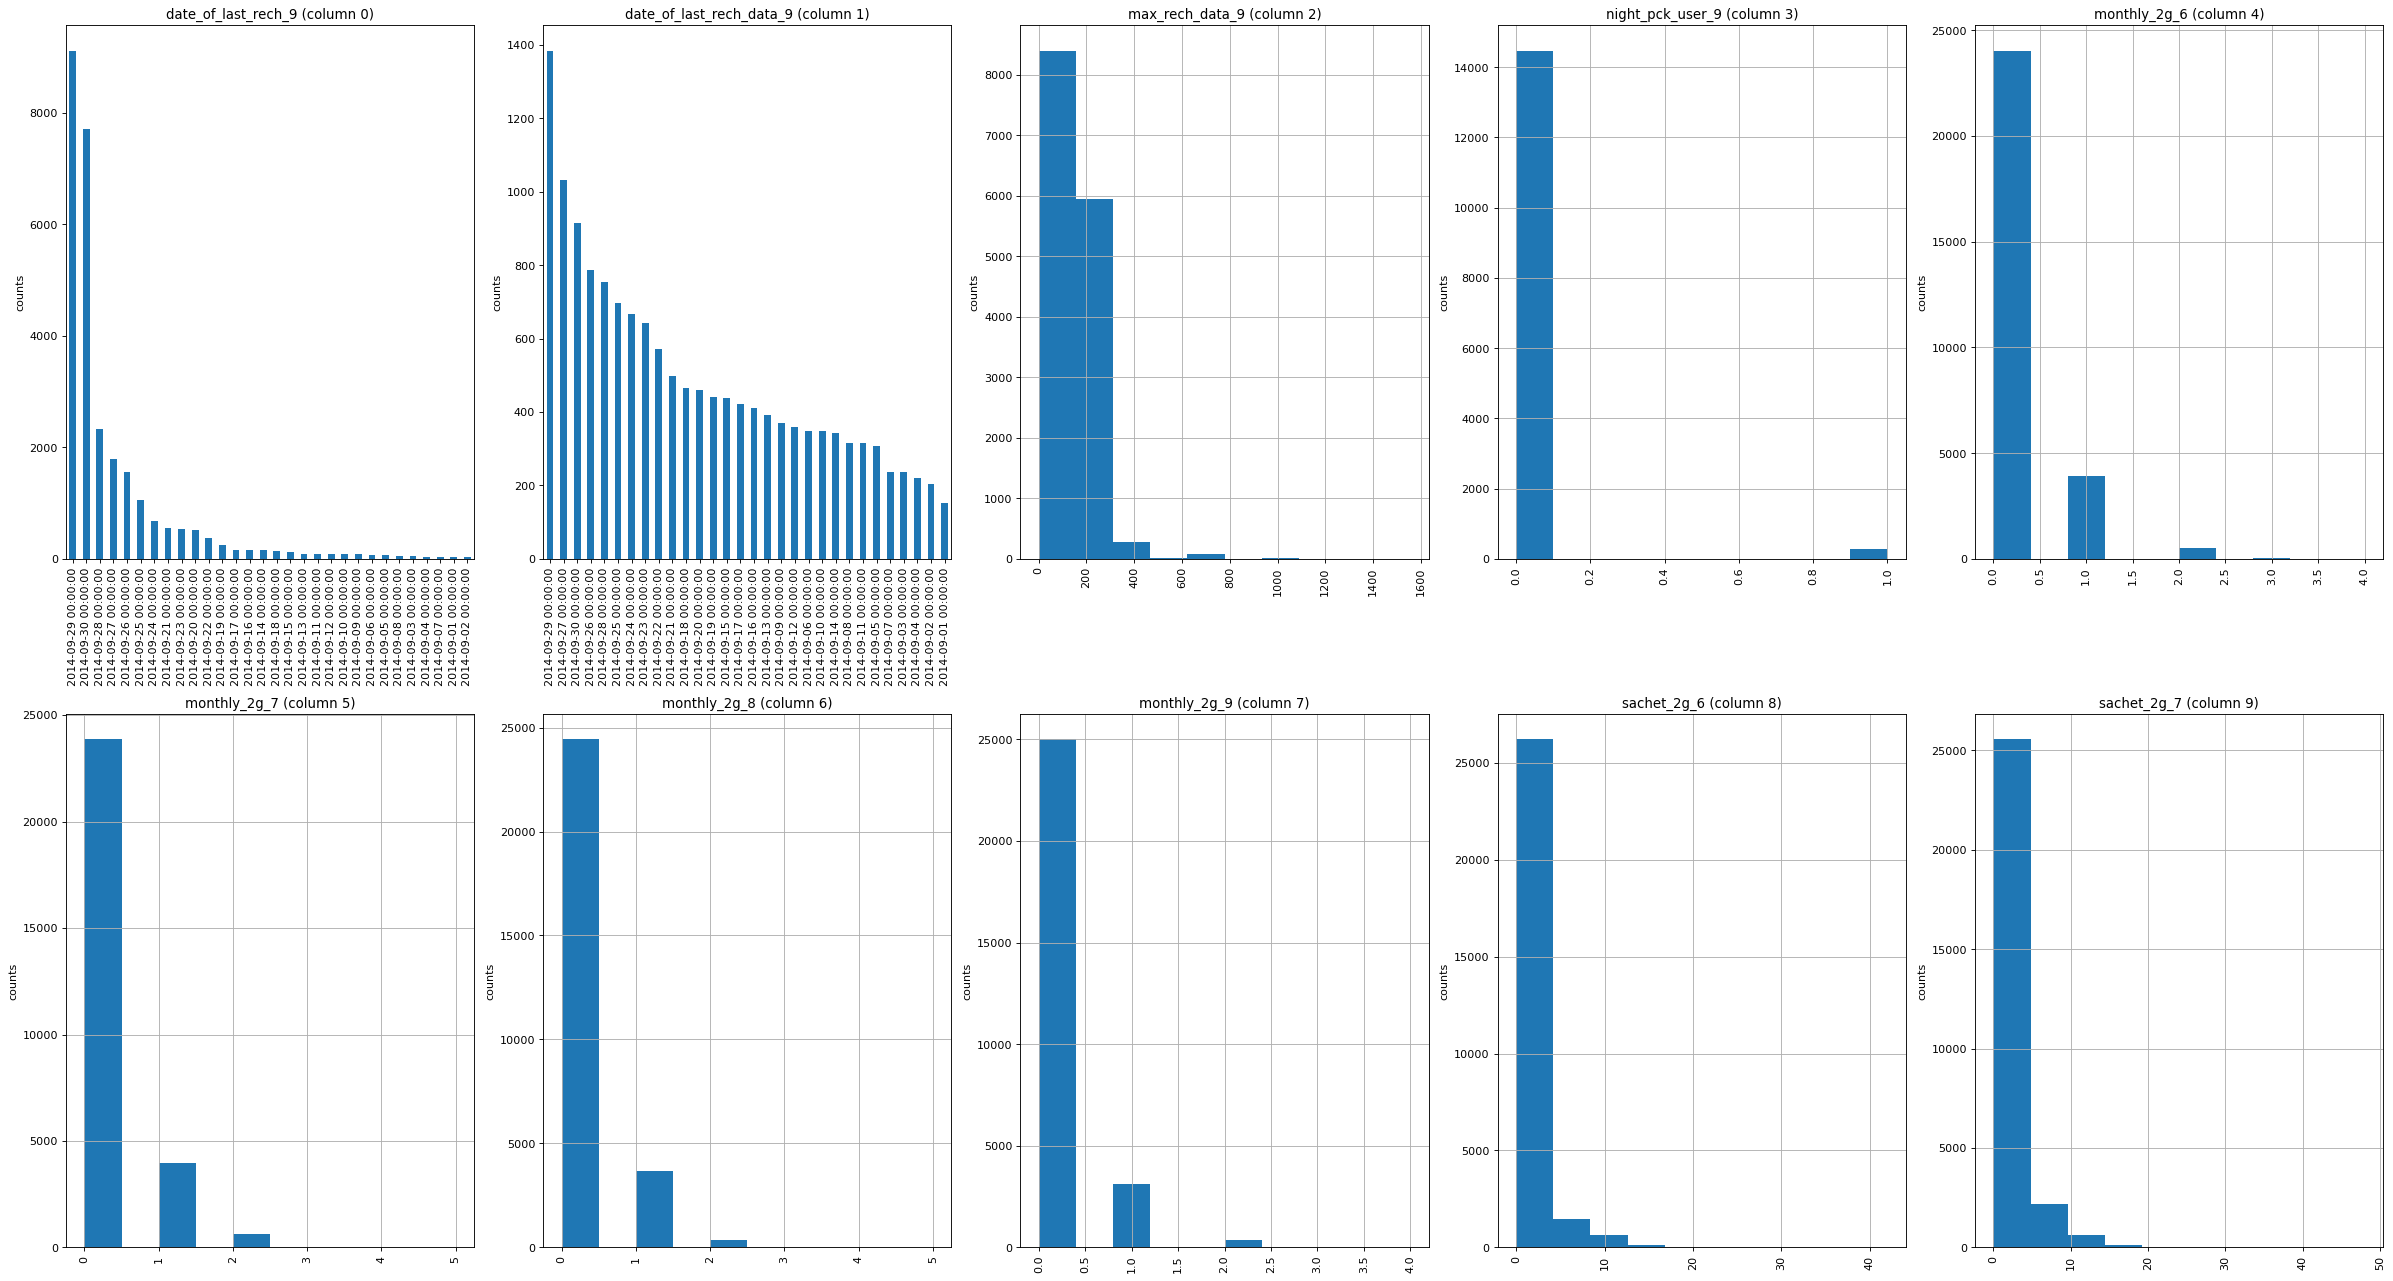

In [94]:
# call the function to plot the graphs
plotPerColumnDistribution(data_telhv, 10, 5)

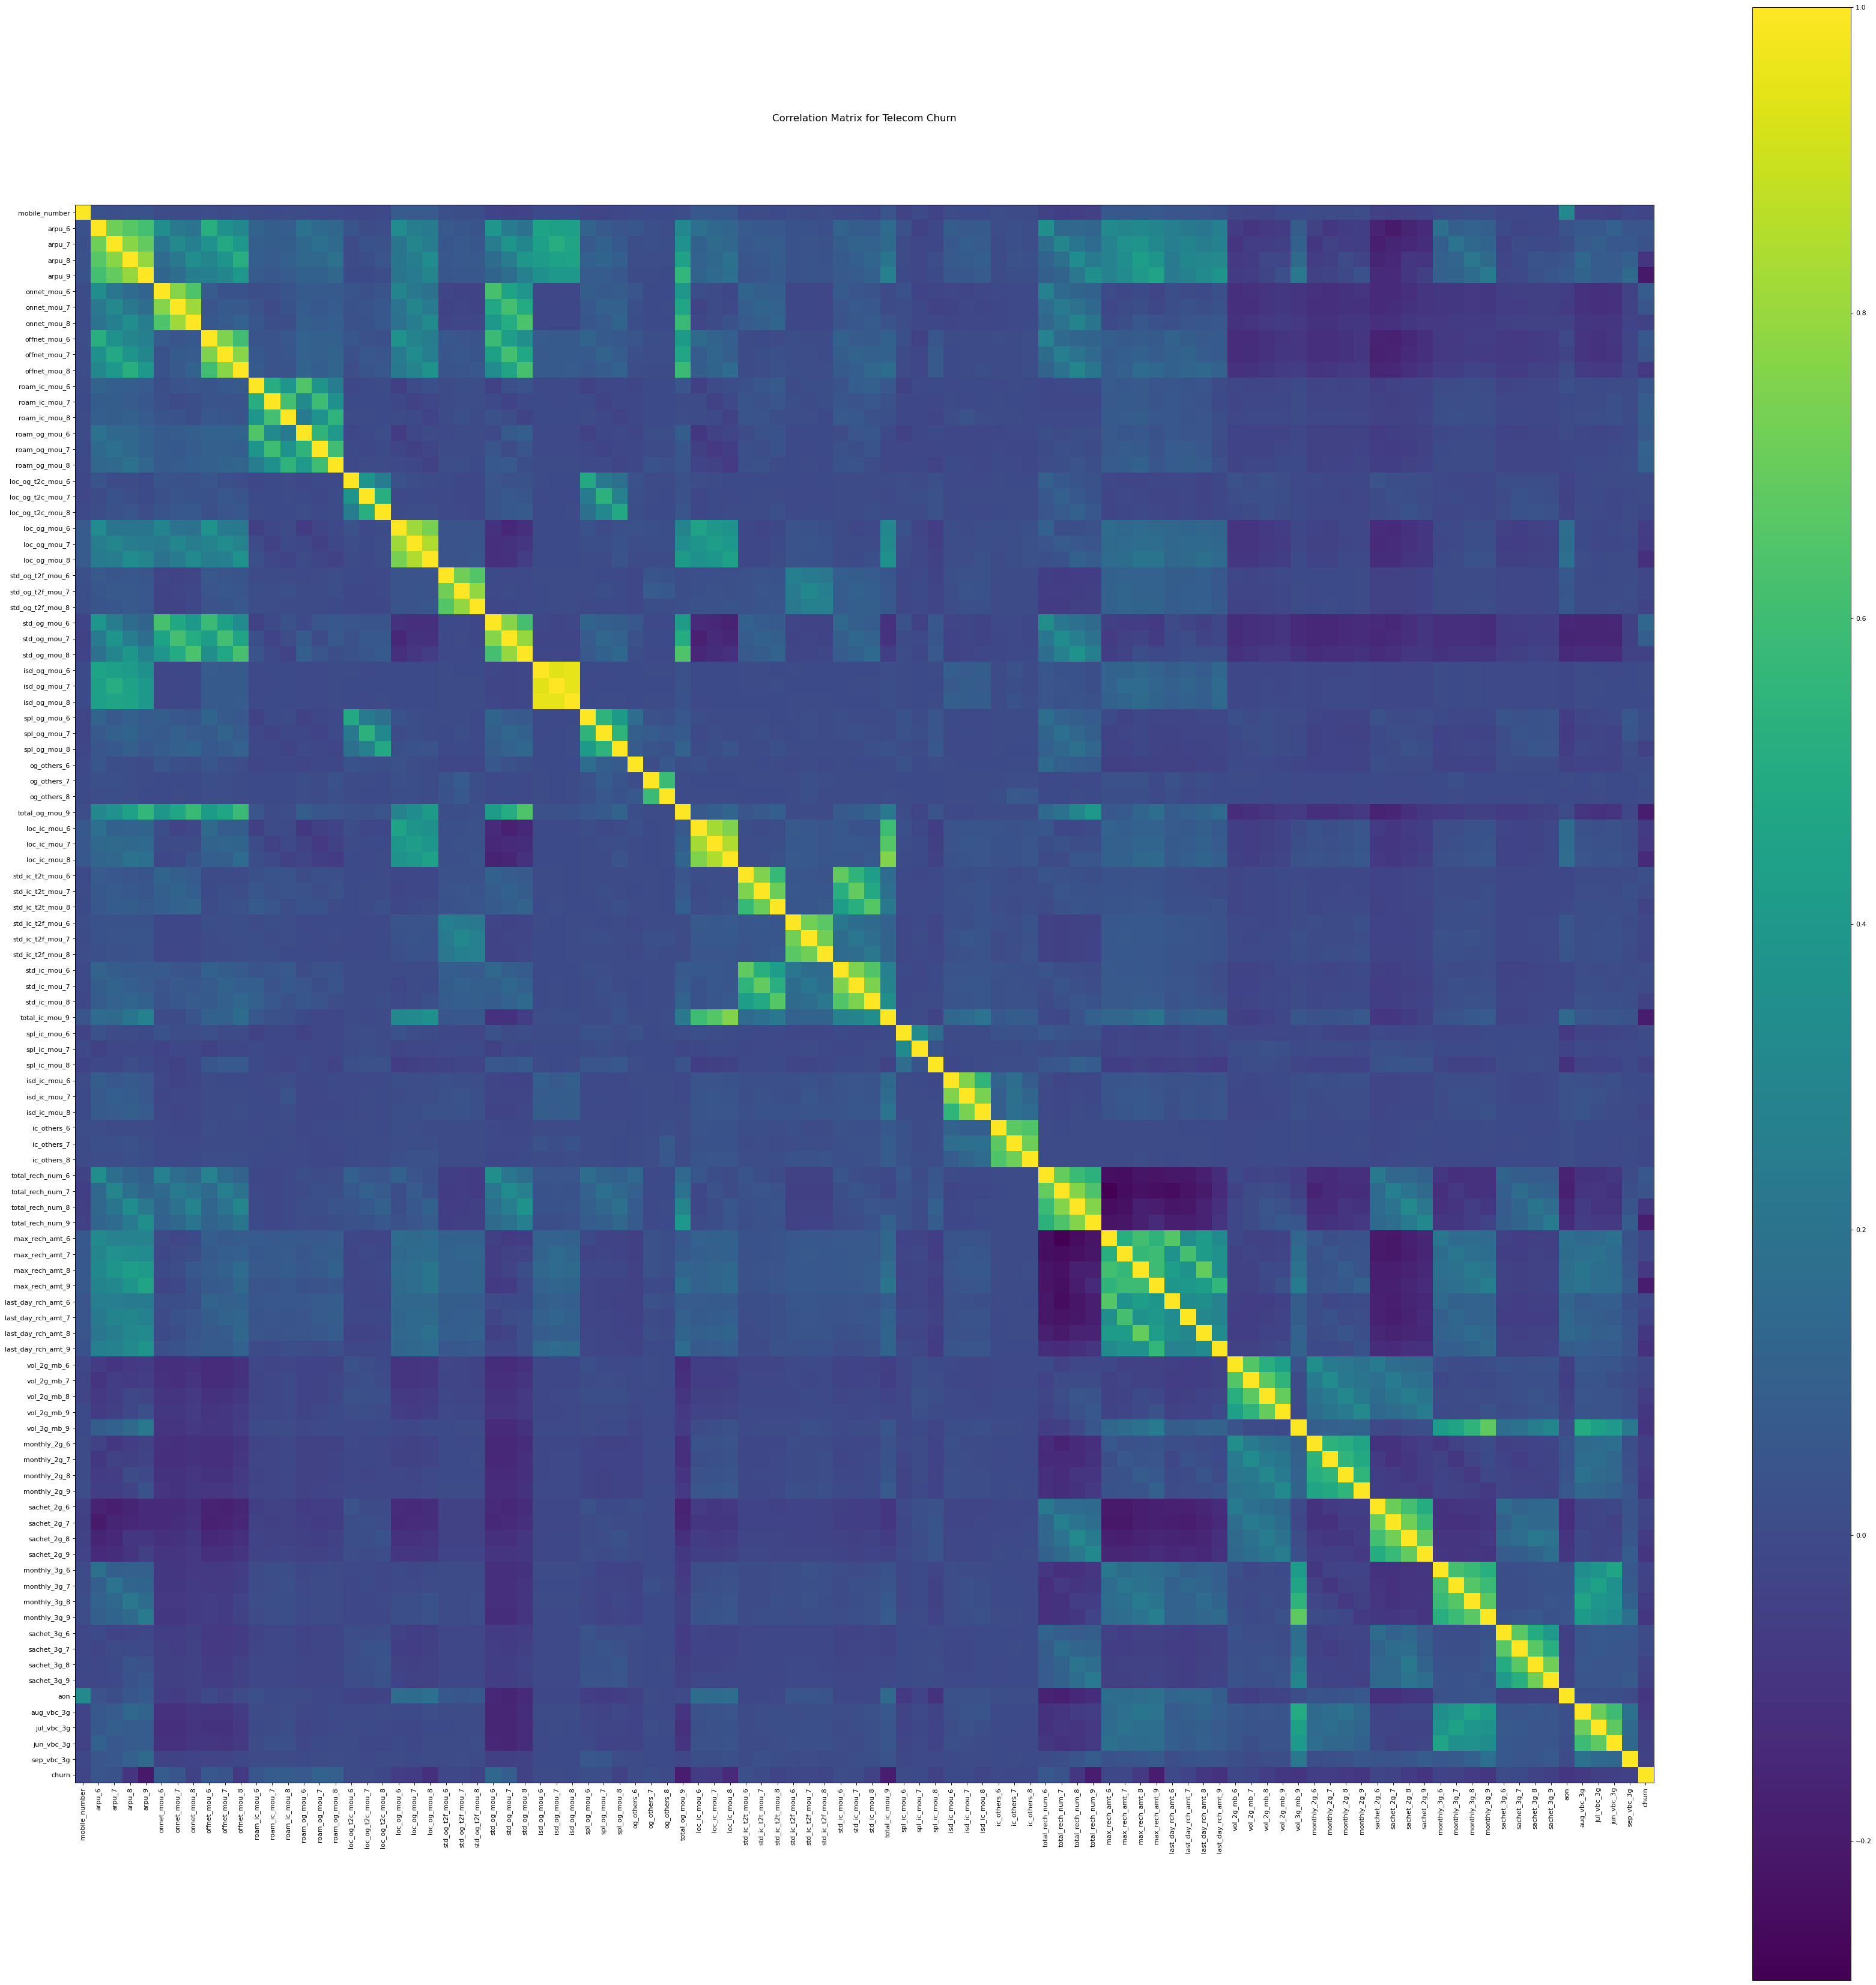

In [95]:
plotCorrelationMatrix(data_telhv, 53)

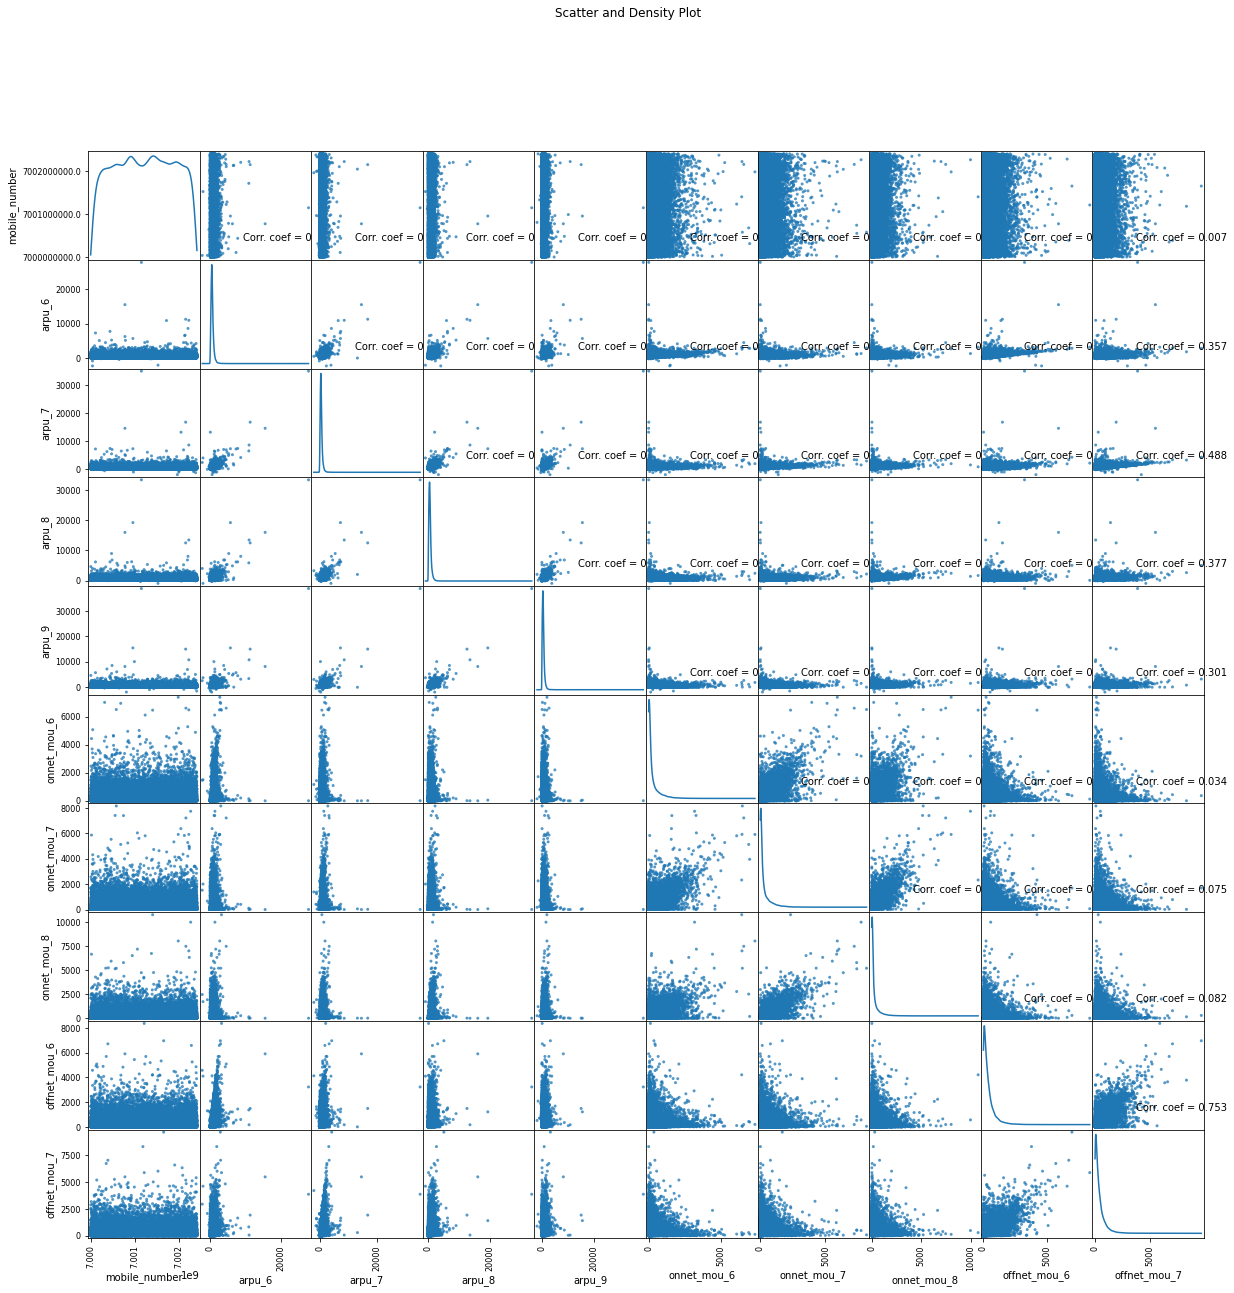

In [96]:
plotScatterMatrix(data_telhv, 20, 10)

# Derive some new feautres from the existing columns

In [97]:
# create a new colulmn, which would be average  of 6th & 7th months
# lets first create list of columns belonging to 6th and 7th months
col_list = data_telhv.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (data_telhv.shape)
# lets take the average now
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    data_telhv[avg_col_name] = (data_telhv[col_6]  + data_telhv[col_7])/ 2



(28504, 125)


In [98]:
# we dont need columns from which we have derived new features, we will drop those columns
print ("dimension of the updated dataset after creating dervied features:",data_telhv.shape)
col_to_drop = data_telhv.filter(regex='_6|_7').columns
data_telhv.drop(col_to_drop, axis=1, inplace=True)

print("dimension of the dataset after dropping un-necessary columns:",data_telhv.shape)

dimension of the updated dataset after creating dervied features: (28504, 152)
dimension of the dataset after dropping un-necessary columns: (28504, 98)


In [99]:
# lets now conevrt AON in months
data_telhv['aon_mon'] = data_telhv['aon']/30
data_telhv.drop('aon', axis=1, inplace=True)
data_telhv['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

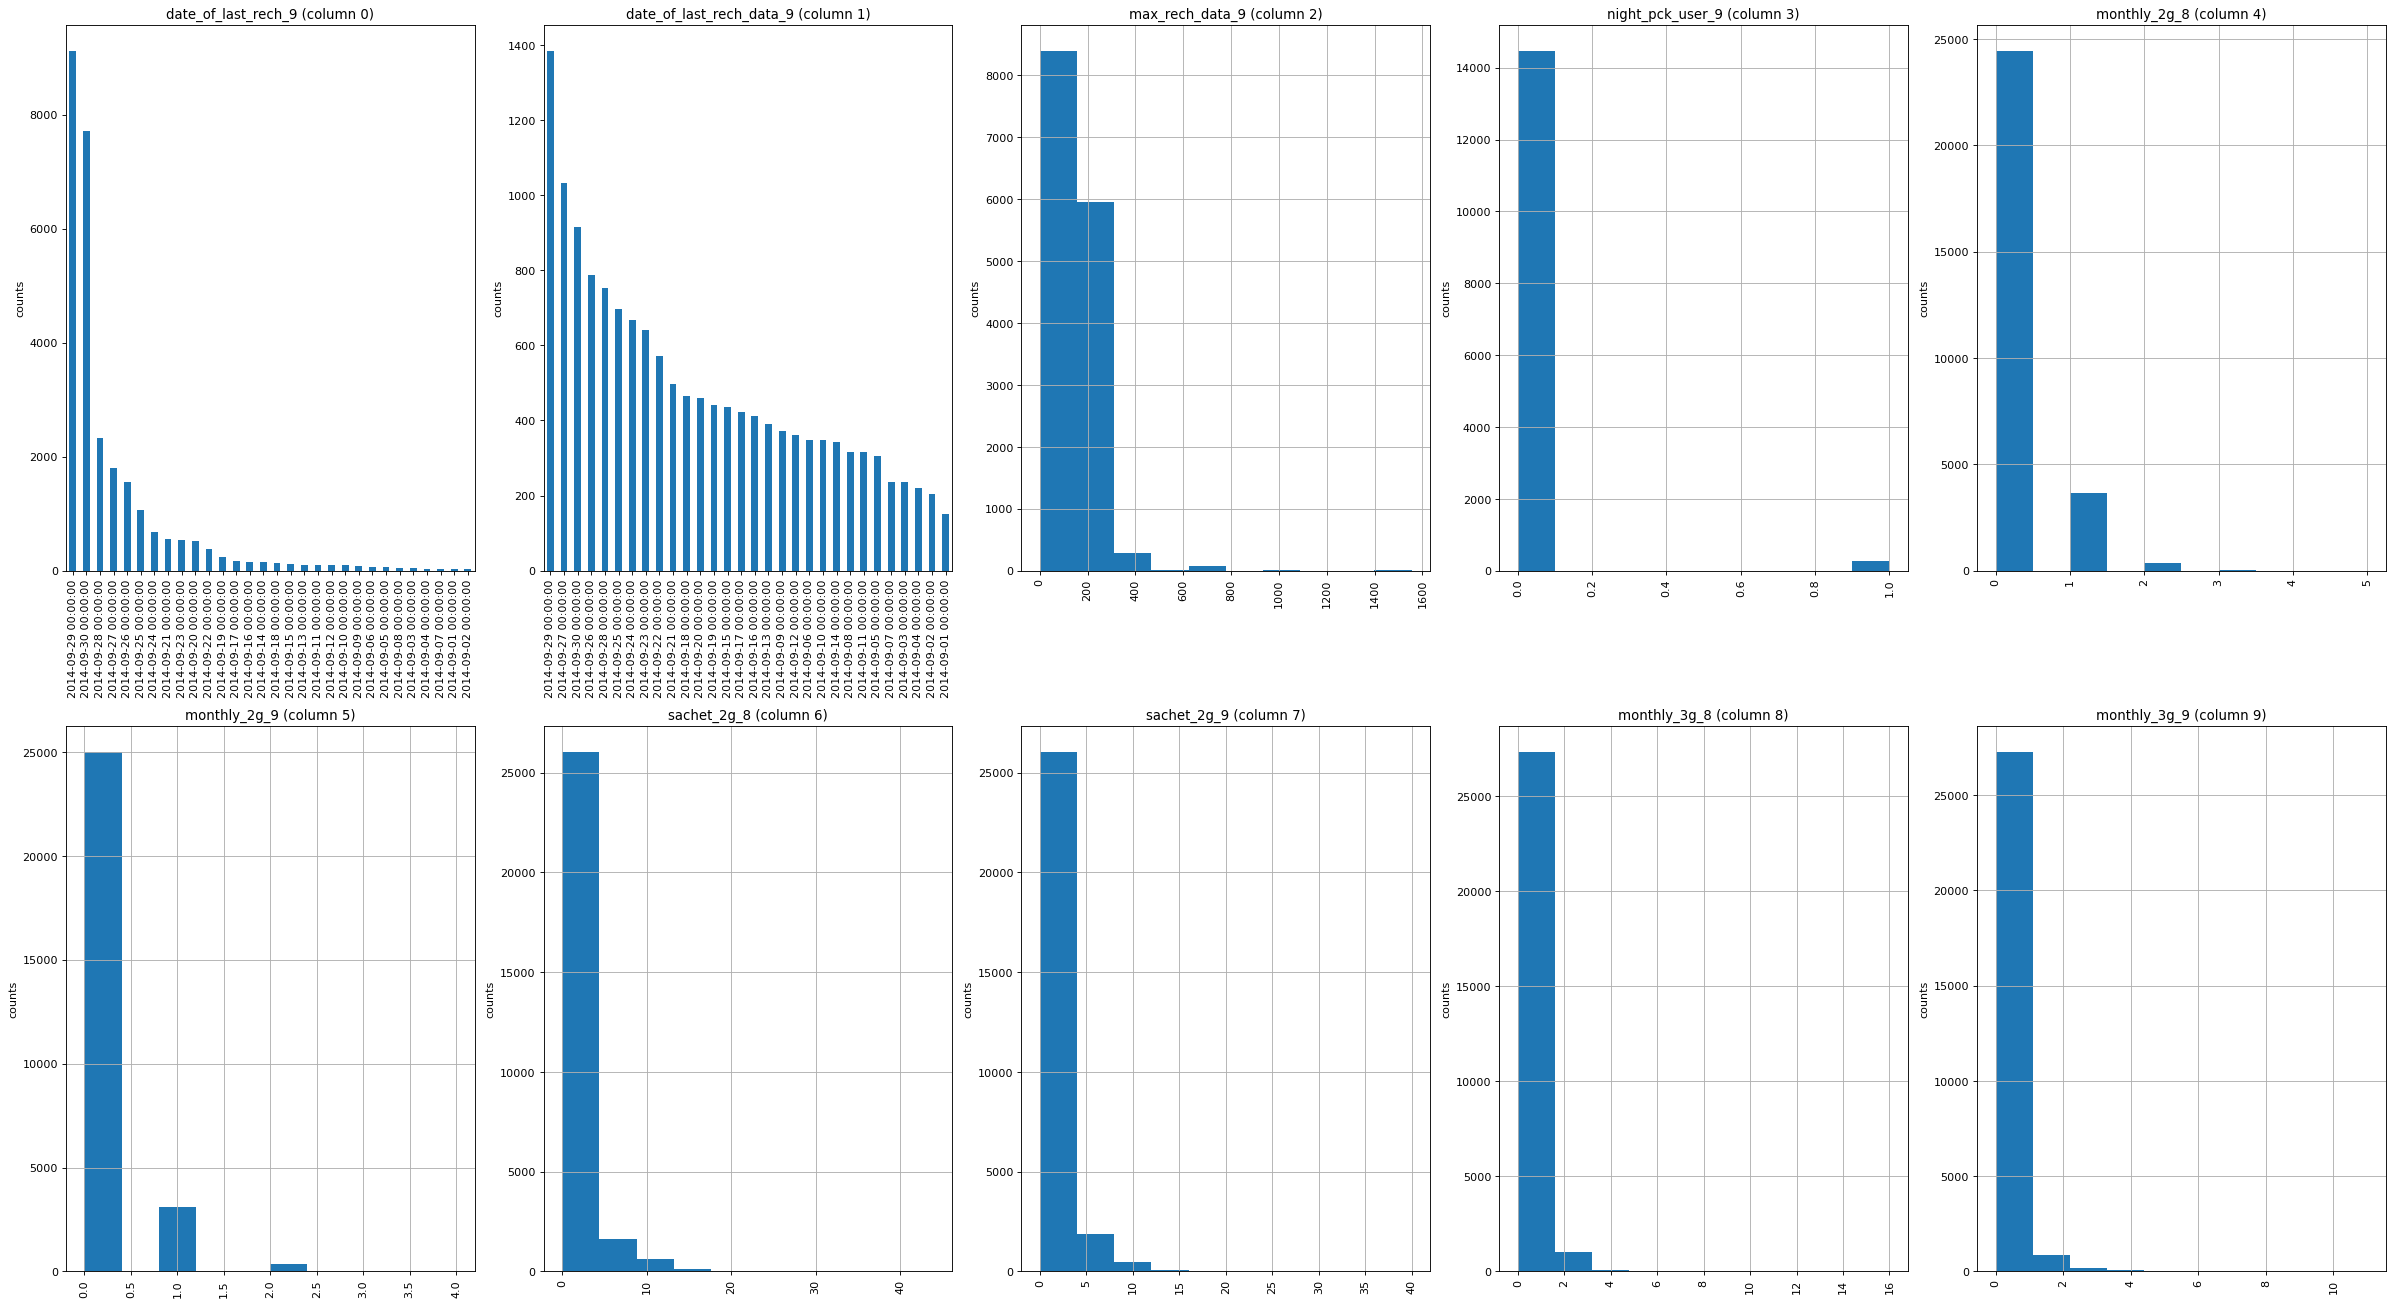

In [100]:
# lets again draw the plots with the updated dataset
plotPerColumnDistribution(data_telhv, 10, 5)

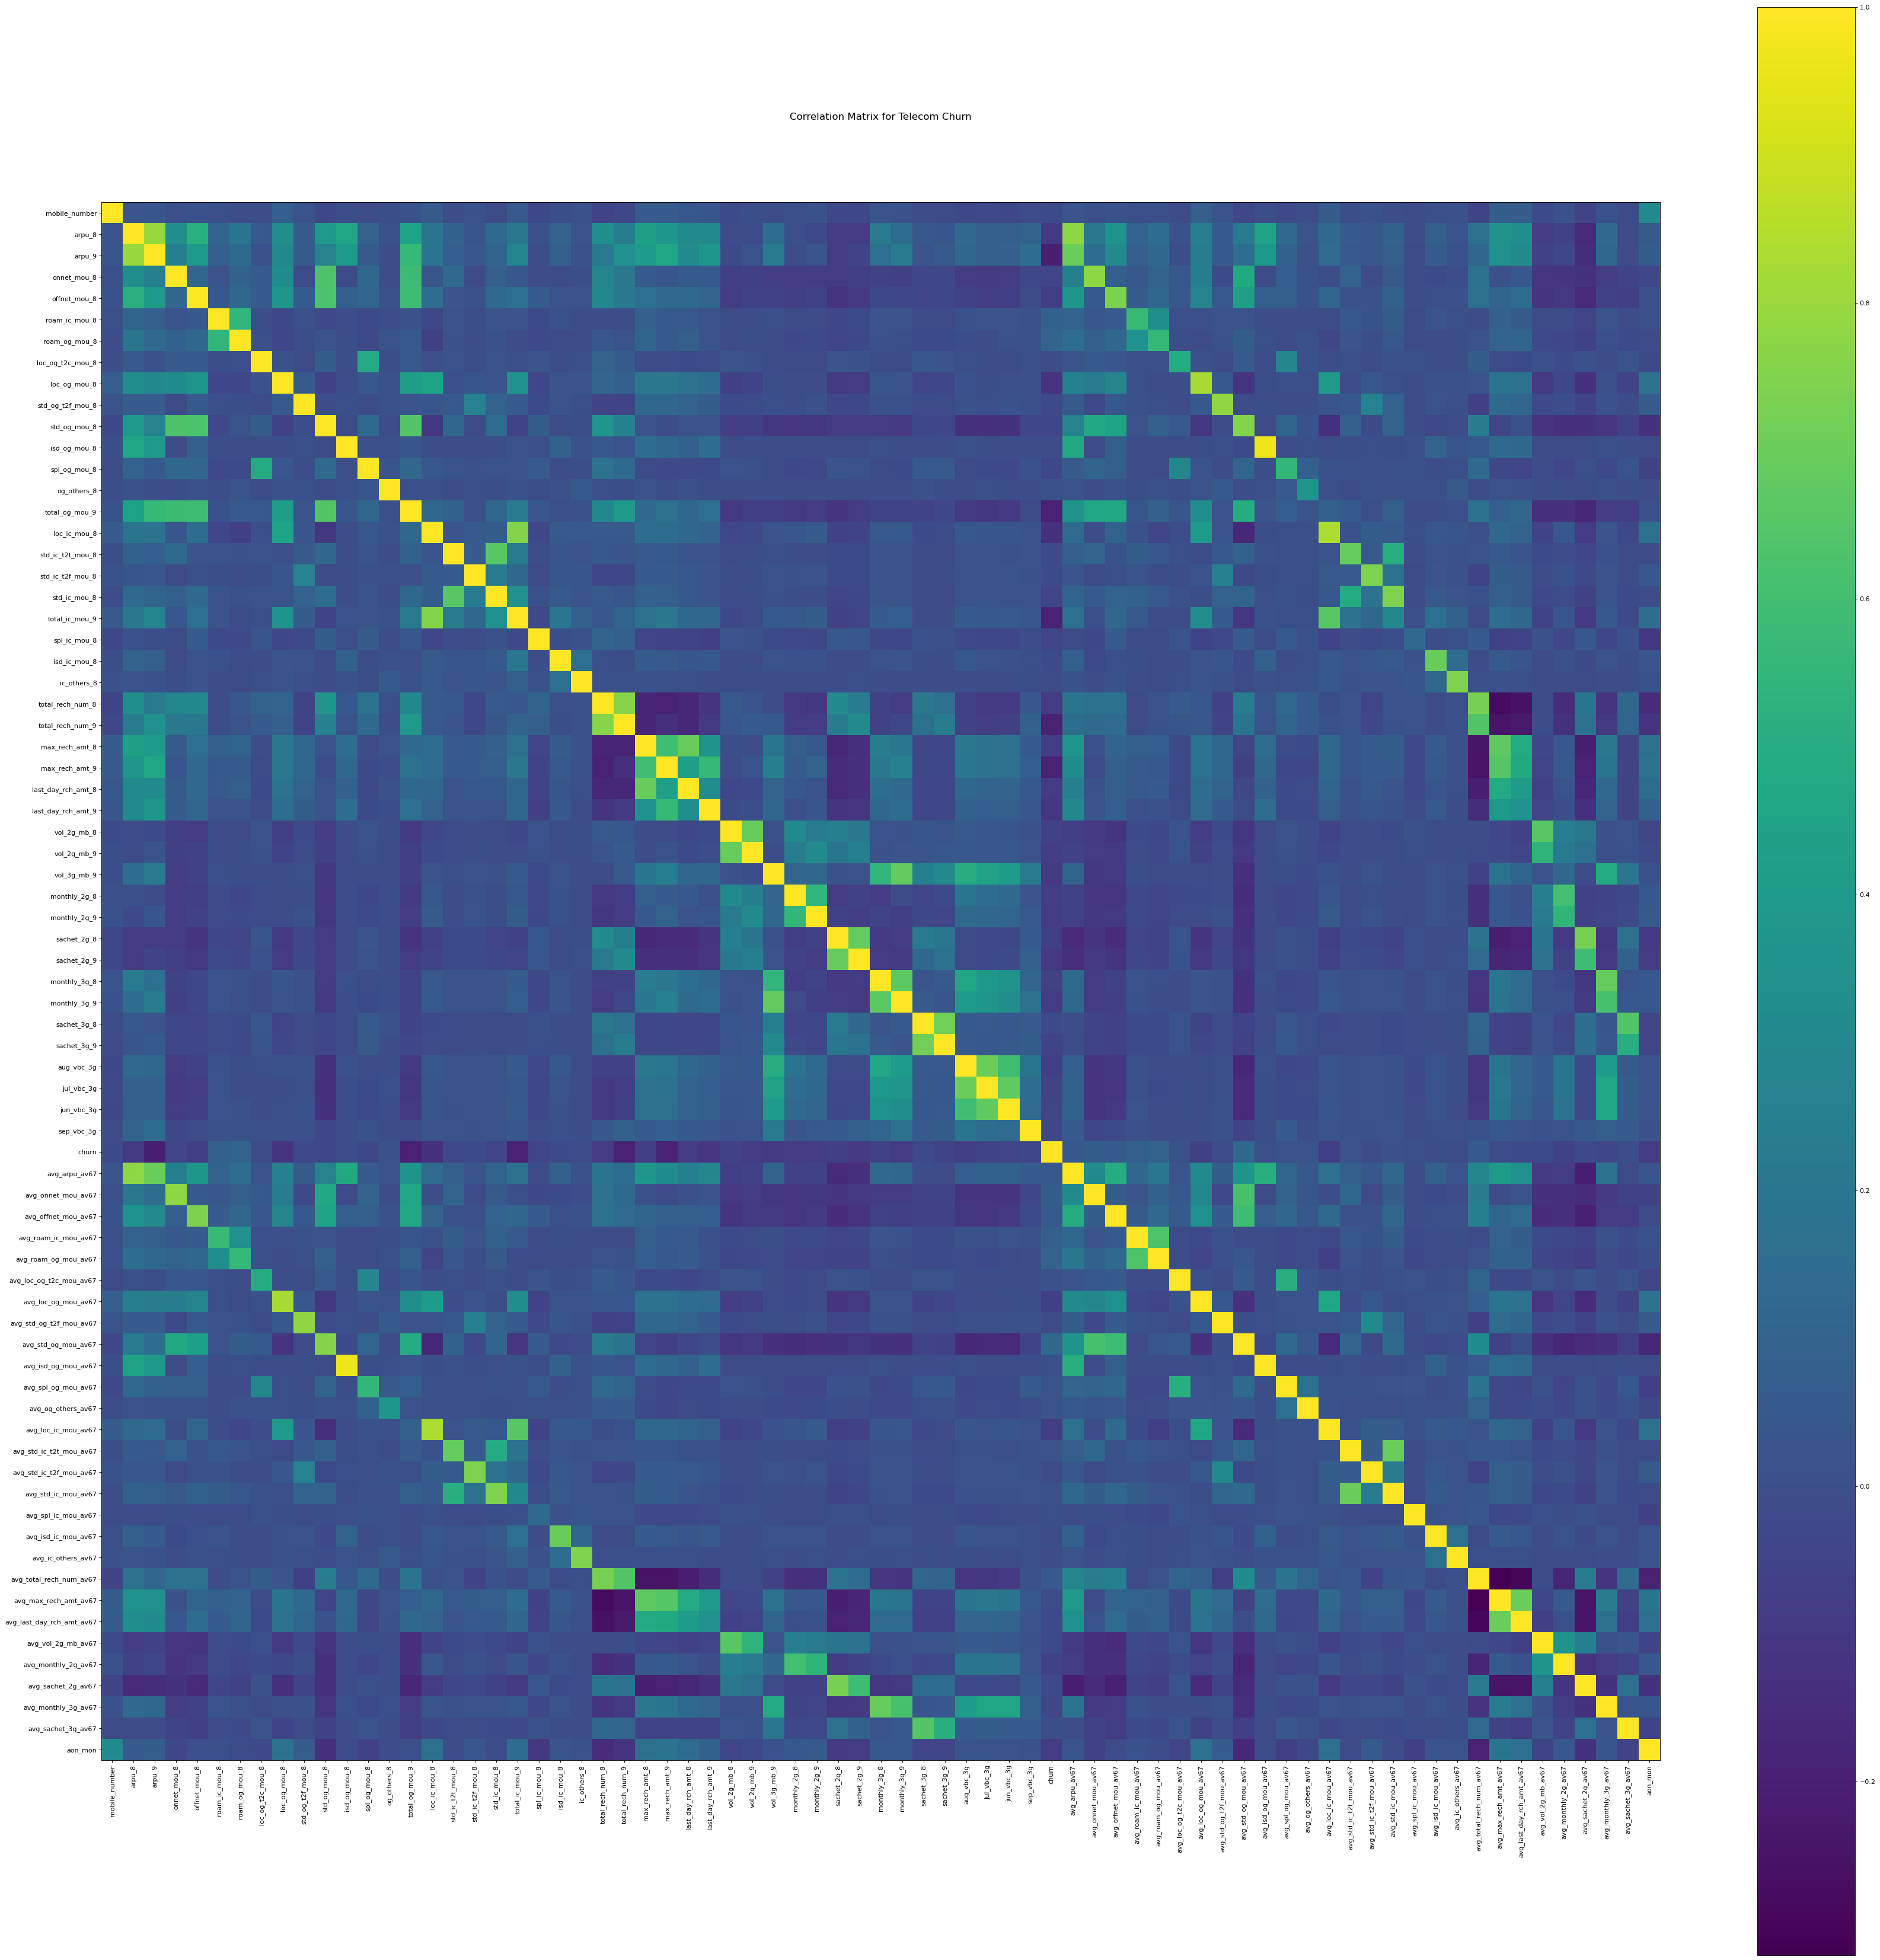

In [101]:
plotCorrelationMatrix(data_telhv, 53)

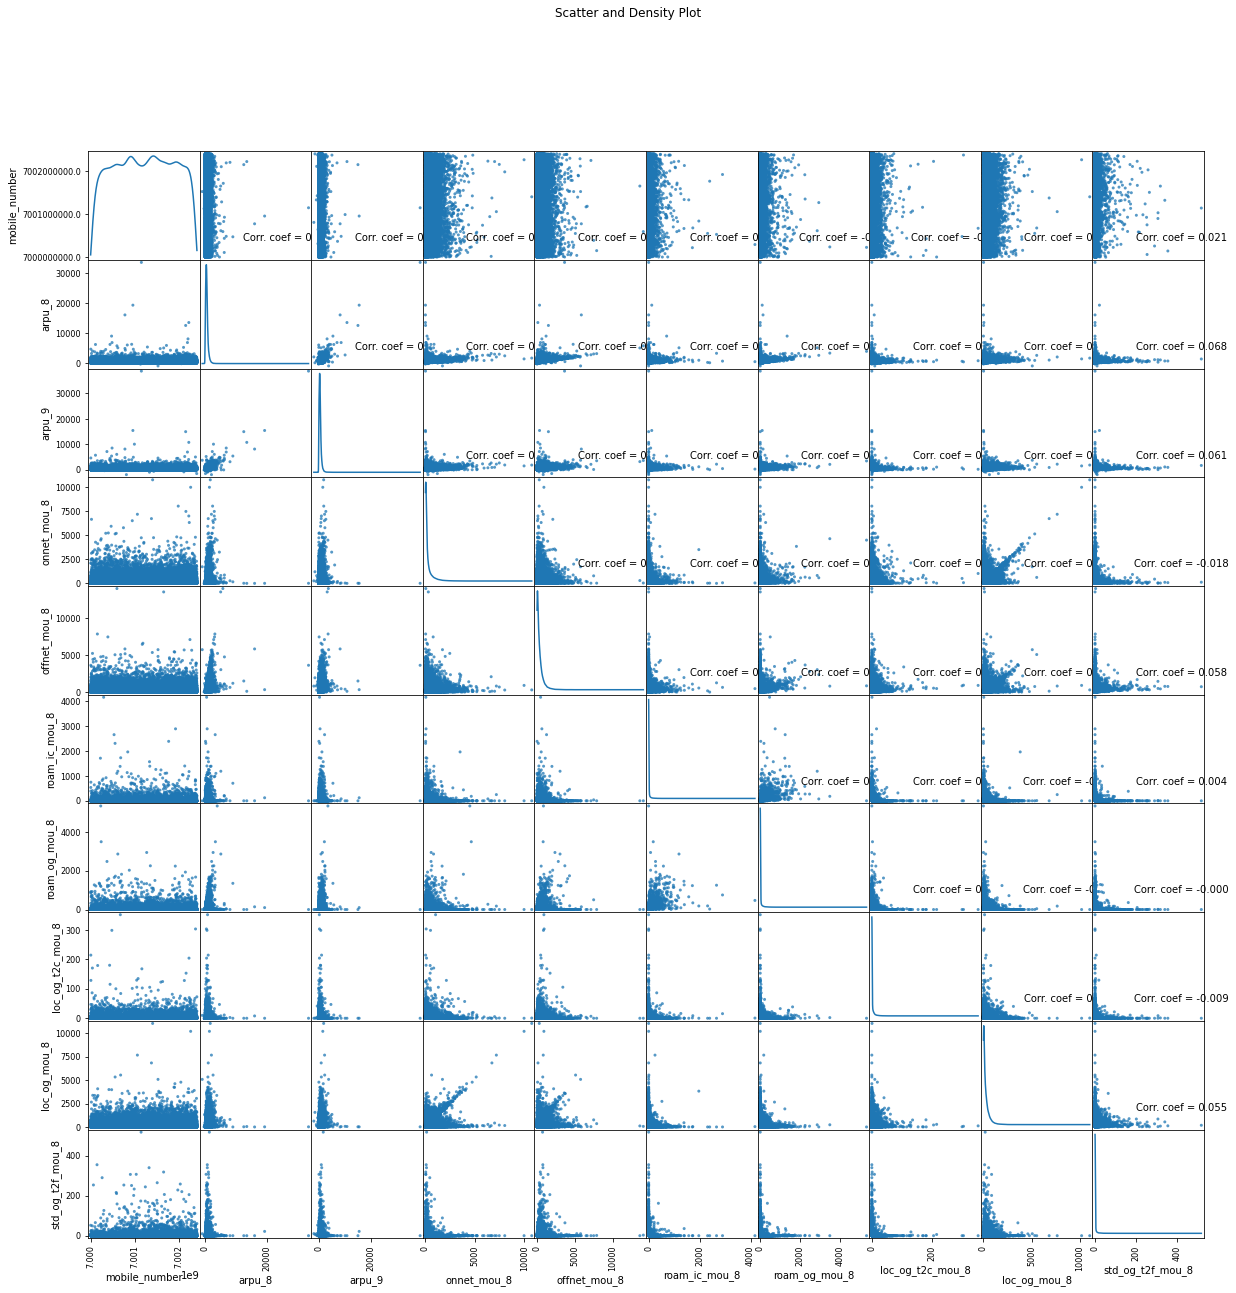

In [102]:
plotScatterMatrix(data_telhv, 20, 10)

Text(0.5, 1.0, 'Tenure Graph')

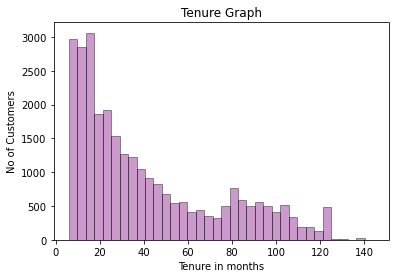

In [103]:
ax = sns.distplot(data_telhv['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')
# below graph simply shows the tenure of the customers

In [104]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_telhv['tenure_range'] = pd.cut(data_telhv['aon_mon'], tn_range, labels=tn_label)
data_telhv['tenure_range'].head()

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

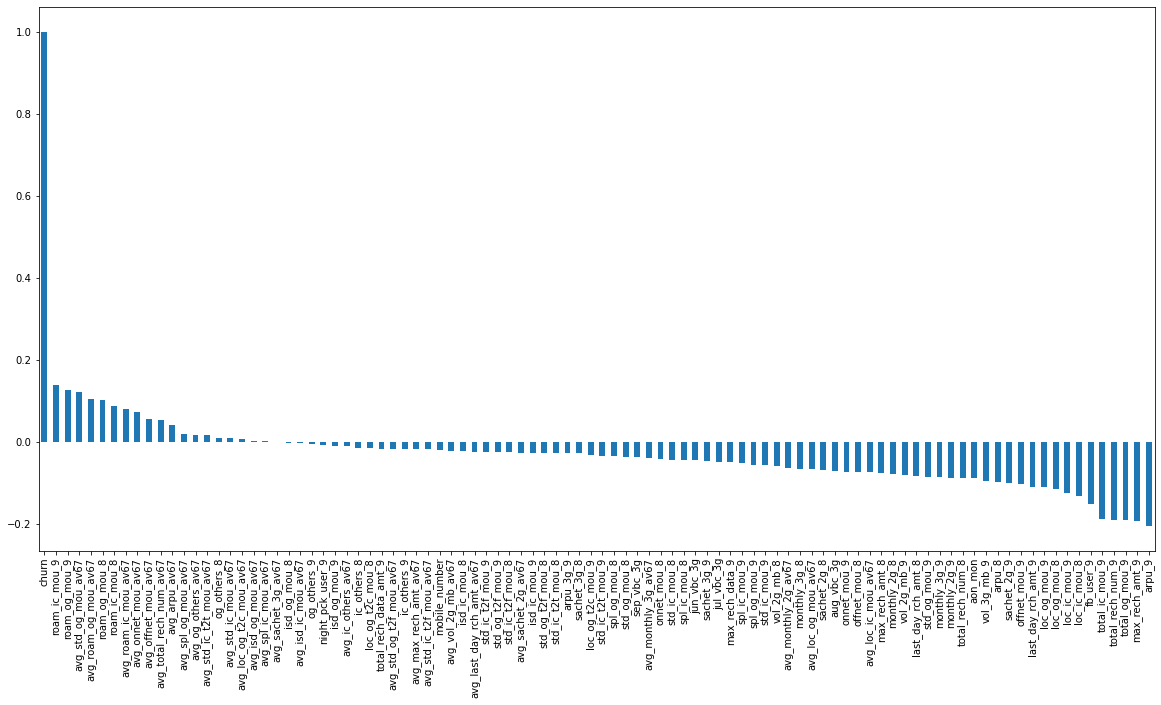

In [105]:
# lets check correlation of churn with other columns
plt.figure(figsize=(20,10))
data_telhv.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

# observations : 
# 1. Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn. 
# 2. Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

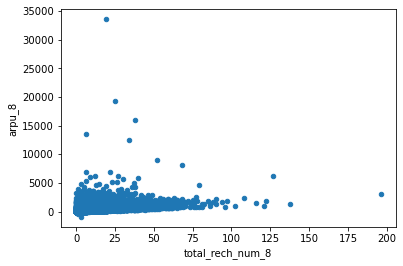

In [106]:
# lets now draw a scatter plot between total recharge and avg revenue for the 8th month
data_telhv[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

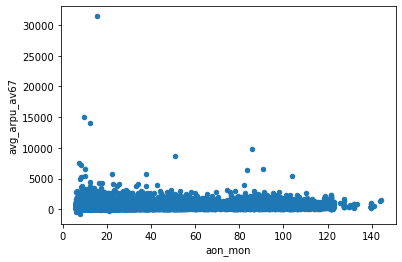

In [107]:
# plot between tenure and revenue
data_telhv[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

# Churn Vs other important features

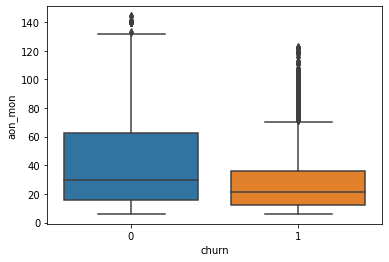

In [108]:
sns.boxplot(x = data_telhv.churn, y = data_telhv.aon_mon)

# from the below plot , its clear tenured customers do no churn and they keep availing telecom services

Text(0.5, 1.0, 'Churn Vs Base Cost')

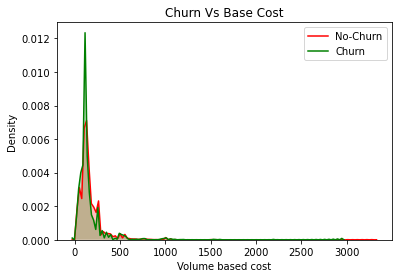

In [109]:
# churn Vs Base Cost
ax = sns.kdeplot(data_telhv.avg_max_rech_amt_av67[(data_telhv["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(data_telhv.avg_max_rech_amt_av67[(data_telhv["churn"] == 1)],
                ax =ax, color="Green", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Churn Vs Base Cost')

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

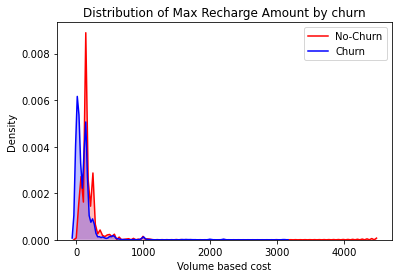

In [110]:
# churn vs max rechare amount
ax = sns.kdeplot(data_telhv.max_rech_amt_8[(data_telhv["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(data_telhv.max_rech_amt_8[(data_telhv["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

In [111]:
# we will create a new dataset for model building
df = data_telhv[:].copy()

# lets drop tenure range because it is highly correlated with AON MONTH column
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)
df.head()

,arpu_8,arpu_9,onnet_mou_8,onnet_mou_9,offnet_mou_8,offnet_mou_9,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_8,roam_og_mou_9,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,500.000,52.29,NaN,325.91,NaN,31.64,NaN,38.06,NaN,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,166.787,35.08,33.46,136.48,108.71,0.00,0.0,0.00,0.0,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,578.596,85.14,161.63,983.39,869.89,0.00,0.0,0.00,0.0,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,811.480,33.58,15.74,205.89,111.88,0.00,0.0,0.00,0.0,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,799.356,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


In [112]:
# lets create X & y dataset for model building, X will obviously not have "churn" and y will only have "churn"
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)


In [114]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

TypeError: invalid type promotion

In [41]:
# split the dateset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


In [42]:
# As discussed earlier, given dataset is skewed, lets balance the dataset
from imblearn.over_sampling import SMOTE

sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)

ModuleNotFoundError: No module named 'sklearn.neighbors._base'

In [43]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

NameError: name 'X_tr' is not defined

In [44]:
# Model Building
# SVM (lets start with linear SVM)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

# linear SVM gave us accuracy of 94% on test data

0.9419400105244694

In [45]:
# we will now using RFE for feature reduction
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# lets RFE select 15 most imp features for us
rfe = RFE(lr, 15)   
rfe = rfe.fit(X_tr, y_tr)

NameError: name 'X_tr' is not defined

In [46]:
rfe_features = list(df.columns[rfe.support_])
print("15 most important features selected by RFE ", rfe_features)

AttributeError: 'RFE' object has no attribute 'support_'

In [47]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

NameError: name 'X_tr' is not defined

In [48]:
# lets create a Logisctic Regression model on the seleted columns by RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

NameError: name 'X_rfe' is not defined

In [49]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print('Accuracy on the test dataset:',lr.score(X_test_rfe, y_test))

AttributeError: 'RFE' object has no attribute 'support_'

In [50]:
# lets check classification report on the test dataset
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined

Conclusion from the above model:

Model Accuracy is approx 79%
Confusion matix shows high false positive rate, which is not good, lets try PCA now.

# PCA

In [51]:
# PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to correct class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


ModuleNotFoundError: No module named 'sklearn.neighbors._base'

In [52]:
# import PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

# apply PCA on train data
pca.fit(X_tr)

NameError: name 'X_tr' is not defined

In [53]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

NameError: name 'X_tr' is not defined

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# make the predictions
y_pred = lr_pca.predict(X_test_pca)

# convert prediction array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

NameError: name 'X_tr_pca' is not defined

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred))

NameError: name 'y_pred' is not defined

In [56]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_pca.head(10)

AttributeError: 'PCA' object has no attribute 'components_'

In [57]:
# scree plot to check the variance explained by different PCAs
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

<Figure size 864x576 with 0 Axes>

In [58]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
# 33 columns explains 90% of the variance, lets apply PCA with 33 components

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [59]:
# PCA with 33 components
pca_33 = PCA(n_components=33)

df_tr_pca_33 = pca_33.fit_transform(X_tr)
print(df_tr_pca_33.shape)

df_test_pca_33 = pca_33.transform(X_test)
print(df_test_pca_33.shape)

NameError: name 'X_tr' is not defined

In [60]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_33, y_tr)

# Predicted probabilities
y_pred33 = lr_pca1.predict(df_test_pca_33)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred33)

print("Accuracy with 33 PCAs: ",accuracy_score(y_test,y_pred33))

NameError: name 'df_tr_pca_33' is not defined

In [61]:
print(confusion_matrix(y_test,y_pred33))

NameError: name 'y_pred33' is not defined

Conclusions from the above model:

Model has 80% Accuracy
33 features can explain 90% variance in the dataset
most imp features: arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8

# Decision Tree

In [62]:
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

ModuleNotFoundError: No module named 'sklearn.neighbors._base'

In [63]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

NameError: name 'X_tr' is not defined

In [64]:
# feature vector for decision tree
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

NameError: name 'position' is not defined

In [65]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [66]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

NameError: name 'position' is not defined

In [67]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

NameError: name 'y_pred1' is not defined

# Lets fine tune hyperparameters

In [68]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [69]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [70]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# max_depth =10 seems to be the optimal one

NameError: name 'score' is not defined

<Figure size 432x288 with 0 Axes>

In [71]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [72]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [73]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_sample_leaf =25 seems to be the optimal one

NameError: name 'score' is not defined

<Figure size 432x288 with 0 Axes>

In [74]:
# lets fine tune min sample split now
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [75]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [76]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_samples_leaf=50 seems to be optimal

NameError: name 'scores' is not defined

<Figure size 432x288 with 0 Axes>

In [77]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [78]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [79]:
print(grid_search.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [80]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [81]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [82]:
# Conclusion from the above Decision Tree model
# 1. 85% accuracy on the test dataset
# 2. lots of false positives in the confusion matrix

# Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

NameError: name 'X_lasso' is not defined

In [84]:
print(classification_report(y_test,prediction_test))

NameError: name 'prediction_test' is not defined

In [85]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

NameError: name 'prediction_test' is not defined

In [86]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [87]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [88]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'scores' is not defined

<Figure size 432x288 with 0 Axes>

In [89]:
##Tuning n_estimators
## GridSearchCV to find optimal n_estimators
#from sklearn.model_selection import KFold
## specify number of folds for k-fold CV
n_folds = 5
#
## parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}
#
## instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)
#
#
## fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [90]:
## scores of GridSearch CV
scores = rf.cv_results_
#
## plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [91]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [92]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [93]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'X_lasso' is not defined

In [94]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [95]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [96]:
# fit the grid search with the data
grid_search.fit(X_lasso, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

NameError: name 'X_lasso' is not defined

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [98]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5399
           1       0.67      0.19      0.29       302

    accuracy                           0.95      5701
   macro avg       0.81      0.59      0.63      5701
weighted avg       0.94      0.95      0.94      5701

[[5371   28]
 [ 245   57]]


In [99]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

Accuracy Score for Random Forest Final Model : 0.9521136642694265


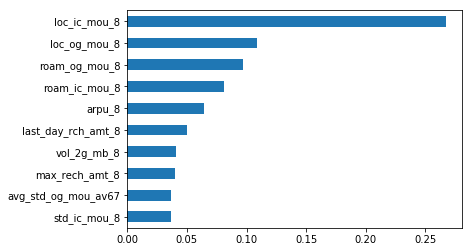

In [100]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

# Conclusions from Random Forest

1. Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.

# Overall Conclusions

1. Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn.
2. Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are the most important columns to predict churn.
3. cutomers with tenure less than 4 yrs are more likely to churn.
4. Max Recharge Amount is a strong feature to predict churn.
6. Random Forest produced the best prediction results followed by SVM.
